# Analysis for Insight Project

## Setup

In [1]:
# import modules
import pandas as pd
import numpy as np
import rootpath

# NLP
from sklearn.metrics.pairwise import cosine_similarity as cos_sim

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  
import seaborn as sns
sns.set_context("poster")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("whitegrid")
sns.set(font_scale = 1.5)

### Locate files

In [2]:
# Set paths for project

# Set rootpath for project
rpath = rootpath.detect()

# Set directory
directory_name = '/data/clean/'

# Set filename
file_name = 'data_tsvd_full.csv'

### Compile data

In [3]:
df_tsvd_full = pd.read_csv(rpath+directory_name+file_name, index_col=0)

In [4]:
df_tsvd_full['product_type'].unique()

array(['face serum', 'face moisturizer', 'face wash', 'toner',
       'toothpaste'], dtype=object)

In [5]:
df_tsvd_full.head()

,product,use_category,brand,brand_generic,product_type,size,price,link,0,1,...,390,391,392,393,394,395,396,397,398,399
0,''Buffet'',treatments and serums,The Ordinary,non_generic,face serum,1.0,14.8,https://www.ulta.com/buffet?productId=pimprod2...,1.192140e-01,-3.804440e-03,...,4.975841e-03,-3.680744e-03,2.543059e-04,-1.989861e-02,-7.760412e-04,4.739525e-03,3.849221e-03,-8.177239e-03,-3.971372e-03,-2.401545e-03
1,''Buffet'' + Copper Peptides 1%,treatments and serums,The Ordinary,non_generic,face serum,1.0,28.9,https://www.ulta.com/buffet-copper-peptides-1?...,1.128972e-01,-5.423432e-03,...,7.069513e-03,-1.534115e-03,1.733428e-03,-2.460251e-02,-6.212722e-03,4.548193e-03,1.157866e-02,-1.369132e-02,-9.901973e-03,-3.717259e-03
2,+Retinol Vita C Power Serum Firming + Brighten...,treatments and serums,Kate Somerville,non_generic,face serum,1.0,98.0,https://www.ulta.com/retinol-vita-c-power-seru...,1.763208e-01,-9.768409e-02,...,-1.618833e-03,1.823084e-04,-5.280194e-03,1.789686e-02,-2.325558e-02,-5.912855e-03,-9.878723e-03,-2.759905e-03,1.271354e-02,-9.616596e-03
3,+Retinol Vitamin C Moisturizer,moisturizer,Kate Somerville,non_generic,face moisturizer,1.7,90.0,https://www.ulta.com/retinol-vitamin-c-moistur...,1.800270e-01,-1.009160e-01,...,-3.876801e-03,-2.827020e-02,-4.686050e-03,-2.194605e-03,-1.696343e-02,1.074598e-02,-6.572581e-03,1.421381e-04,3.262727e-03,-6.652446e-03
4,100% Plant-Derived Squalane,treatments and serums,The Ordinary,non_generic,face serum,1.0,7.9,https://www.ulta.com/100-plant-derived-squalan...,3.152109e-17,2.409649e-14,...,2.049383e-07,-2.436632e-07,-2.774561e-07,-2.640047e-07,-2.182120e-07,2.153553e-07,1.834869e-07,1.445371e-07,-1.898183e-07,-2.561501e-07


# Analysis: Cosine similarity

## Determine number of components to extract for LSA

In [13]:
def get_features(df, prod_info):
    """
    Purpose: extract ingredient features from tsvd dataframe
    Returns: df of ingredient features only
    df: df of tsvd and product info
    prod_info: list of strings of column names to remove
    """
    df_tsvd_full_features = df.drop(prod_info, axis=1) \
                                    .set_index('product')
    
    return df_tsvd_full_features

In [15]:
# Separate features from product information

prod_info = ['use_category', 'brand', 'brand_generic', 'product_type',
             'size', 'price', 'link']

df_tsvd_full_features = get_features(df_tsvd_full, prod_info)

In [16]:
def filter_string(list_of_strings, string_to_remove):
    """
    Purpose: filters a string(s) from a list of strings
    Returns: a list without the indicated string(s)
    string_to_remove: MUST BE A LIST
    """
    new_list = [string for string in list_of_strings \
                    if string not in string_to_remove]
    return new_list

In [17]:
# Extract brand_generic product labels

brand_gen_labels = (
    filter_string(df_tsvd_full['brand_generic'].unique(),'non_generic')
)

In [18]:
# List of brand name product brands 
# This does not include their generic versions

brand_names = ['Aveeno','Banana boat','Cetaphil','Clean and Clear',
               'St. Ives']

In [19]:
# Extract df of brand_generic products for comparison to similarity output

# Get columns of product info only

df_brand_gen = (
    df_tsvd_full[df_tsvd_full.columns.intersection(prod_info)].copy()
)

# Add product

df_brand_gen['product'] = df_tsvd_full['product']

# Filter out only brand_generic products

df_brand_gen = df_brand_gen.query('brand_generic == @brand_gen_labels')

In [20]:
# Extract product names for brand name products only
# These are the input products for checking recommendation
#   accuracy for specific products

brand_name_prod = (
    df_tsvd_full.query('brand_generic == @brand_gen_labels and \
                        brand == @brand_names')['product']
)

In [21]:
def reorder_first_cols(df, col_order):
    '''
    Reorder columns in dataframe with col_order as a list of column names
    in the order you want them in to appear at the beginner of the dataframe.
    The rest of the columns will remain in the same order as before. 
    '''
    # Create new column ordering
    new_col_order = (
          col_order + [col for col in df.columns if col not in col_order]
    )
    # Reindex columns based on new order
    df = df.reindex(columns=new_col_order)
    
    return df

In [22]:
def add_prod_info(new_df, original_df, col_names, prod_names_col):
    """
    Purpose: Add product information to TSVD dataframe
    Returns: dataframe with product information in rows and columns
    new_df: df with cosine similarity results results
    original_df: df before tsvd with product information
    col_names: List of strings of column names to be added into tsvd df
    prod_names_col: Name of column with product names, string
    """
    # Add product names
    new_df['product']=original_df[prod_names_col]
    # Copy columns to new df
    col_copy = original_df[col_names].copy()
    # Copy product names to col names df
    col_copy['product'] = original_df[prod_names_col]
    # Join with tsvd df on product
    new_df = pd.merge(new_df, col_copy, how='inner', on='product')
    # Reorder df columns
    cols_order = ['product','cosine_sim', 'use_category','brand',
                  'brand_generic','size','price','link']
    new_df = reorder_first_cols(new_df, cols_order)
    return new_df

In [135]:
def get_ranks(prod_list, prod_df, feat_df):
    """
    Purpose: Get the ranks of labeled recommendations
        for list of products.
    Returns: df of the ranks for each input product in prod_list
    prod_list: list of product names for calculating cosine similarities
    prod_df: dataframe of cosine sim with products as rows 
    feat_df: dataframe of cosine sim only with products as indices
    """
    
    # Set initial value for number of valid recommendations
    input_prod = []
    cos_rank = []

    # Check recommendation rank for each product in prod_list
    for product in prod_list: 
        # Calculate Cosine Similarities
        res_cosine = (
            cos_sim(feat_df.loc[[product],:],
                              feat_df)
        )
        # Convert to df
        res_cosine = pd.DataFrame(res_cosine.transpose()) \
                       .rename(columns={0:'cosine_sim'})
        # Add product info to cosine sim results
        df_cos_sim = add_prod_info(new_df=res_cosine,
                                   original_df=prod_df,
                                   col_names=prod_info, 
                                   prod_names_col='product')
        # Round to 4 digits
        df_cos_sim['cosine_sim'] = df_cos_sim['cosine_sim'].round(4)
        # Filter df without input product 
        #   (should always be with cosine sim of 1)
        df_cos_sim = (
            df_cos_sim[~df_cos_sim['product'].isin([product])]
        )
        # Get brand generic label for input product
        input_prod_label = (
            df_brand_gen.query('product in @product')['brand_generic']
        )
        # Create ranking index for cosine similarity
        df_cos_sim['cos_rank'] = (
            df_cos_sim['cosine_sim'].rank(ascending=False)
        )
        # Set index based on cosine ranking
        df_cos_sim = df_cos_sim.set_index('cos_rank').sort_index()
        # Find matching row of brand generic label and extract index rank
        res_index = df_cos_sim.query('brand_generic in \
                                     @input_prod_label').index.values
        # Save the input product, comparison product, similarity 
        input_prod.append(product)
        cos_rank.extend(res_index)
        # Add lists together and turn into df 
        df_rr = (
            pd.DataFrame(list(zip(input_prod, cos_rank)),
                         columns=['input_prod','cos_rank'])
        )
    
    return df_rr

In [136]:
# Get recommendation accuracy for list of brand name products
df_valid_ranks = get_ranks(brand_name_prod, prod_df=df_tsvd_full,
                                feat_df=df_tsvd_full_features)

In [137]:
# Check values of ranks 
df_valid_ranks

,input_prod,cos_rank
0,Aveeno Positively Radiant Brightening & Exfoli...,1.0
1,"Banana Boat Ultra Sport Sunscreen Lotion, Broa...",1.0
2,Cetaphil Daily Facial Cleanser,1.0
3,Cetaphil Fragrance Free Moisturizing Cream,1.0
4,Clean & Clear Essentials Deep Cleaning Toner S...,39.0
5,"St. Ives Fresh Skin Face Scrub, Apricot",1.0


Text(0, 0.5, 'Counts')

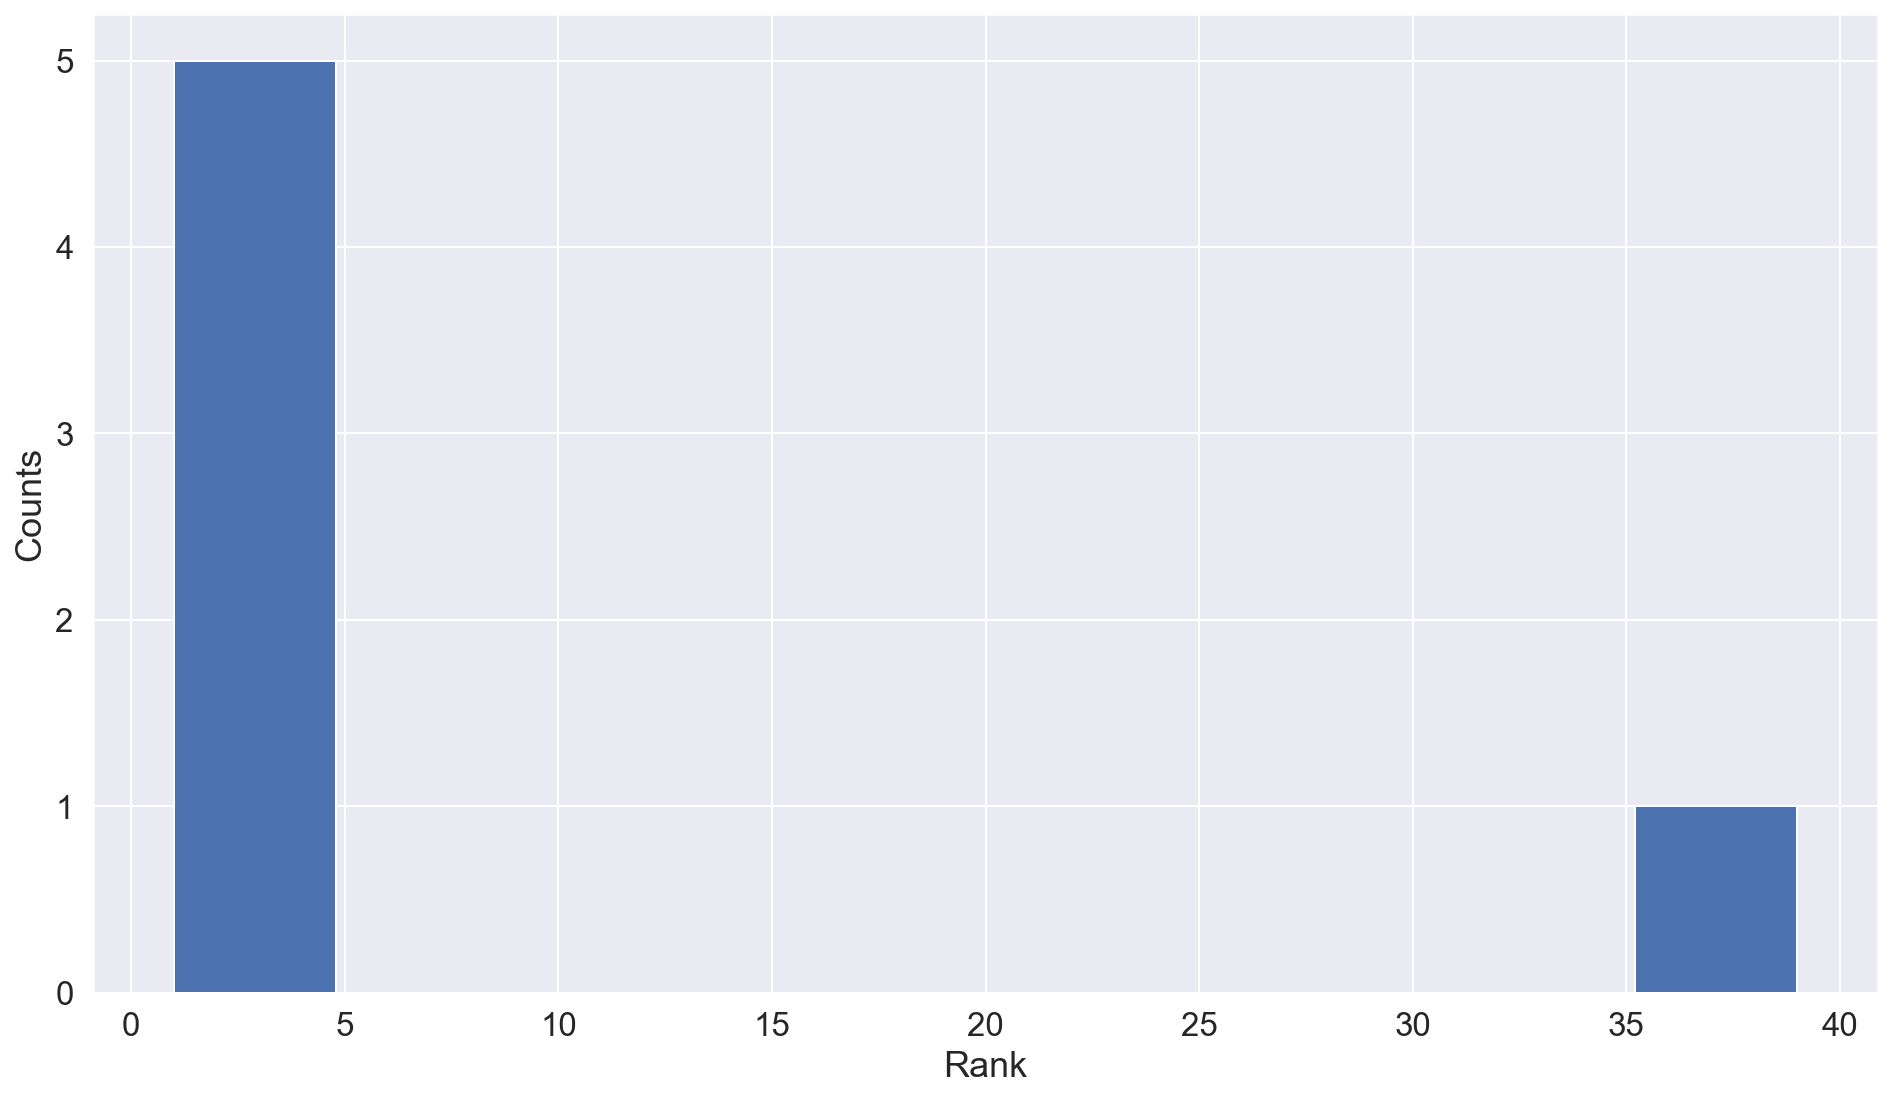

In [140]:
# Check distribution of ranks 

df_valid_ranks.hist()
plt.title('')
plt.xlabel('Rank')
plt.ylabel('Counts')

- Right skewed
- Median will favor the left but costly to not account for errors, so use mean rank

In [146]:
def get_components_df(df, ending_component):
    """
    Purpose: Extract a range of n components from dataframe
    Returns: DF with a range of n components
    starting_comp: string label of the component column to start at
    ending_component: string label of the component column to end at
    """
    # Select n number of components
    df_tsvd_reduced = df.loc[:, '0':str(ending_component)]
    # Set index as product
    df_tsvd_reduced.index = df['product']
    return df_tsvd_reduced

In [186]:
# Get recommendation accuracy for each number of components

component_n = []
comp_mrr = []

for component in range(50,400):
    # Get df of the component features
    df_comp = get_components_df(df_tsvd_full, str(component))
    # Get recommendation ranks for list of brand name products
    df_valid_ranks = get_ranks(brand_name_prod, prod_df=df_tsvd_full,
                                    feat_df=df_comp)
    # Check recommendation mean reciprocal rank for list of 
    # brand name products
    mrr = df_valid_ranks['cos_rank'].mean()
    # Add recommender accuracy and component to lists
    component_n.append(component)
    comp_mrr.append(mrr)
    
# Create df of results
df_comp_res = pd.DataFrame(list(zip(component_n, comp_mrr)),
                          columns=['n_components','MRR'])

In [187]:
# Save component results

filename = 'component_accuracy.csv'

df_comp_res.to_csv(rpath+directory_name+filename)

In [188]:
# Check the MRR distribution

df_comp_res['MRR'].describe()

count    350.000000
mean      24.739286
std       24.646661
min        7.166667
25%        8.854167
50%       14.333333
75%       25.500000
max      104.500000
Name: MRR, dtype: float64

Text(0, 0.5, 'Mean Reciprocal Rank of Recommendations')

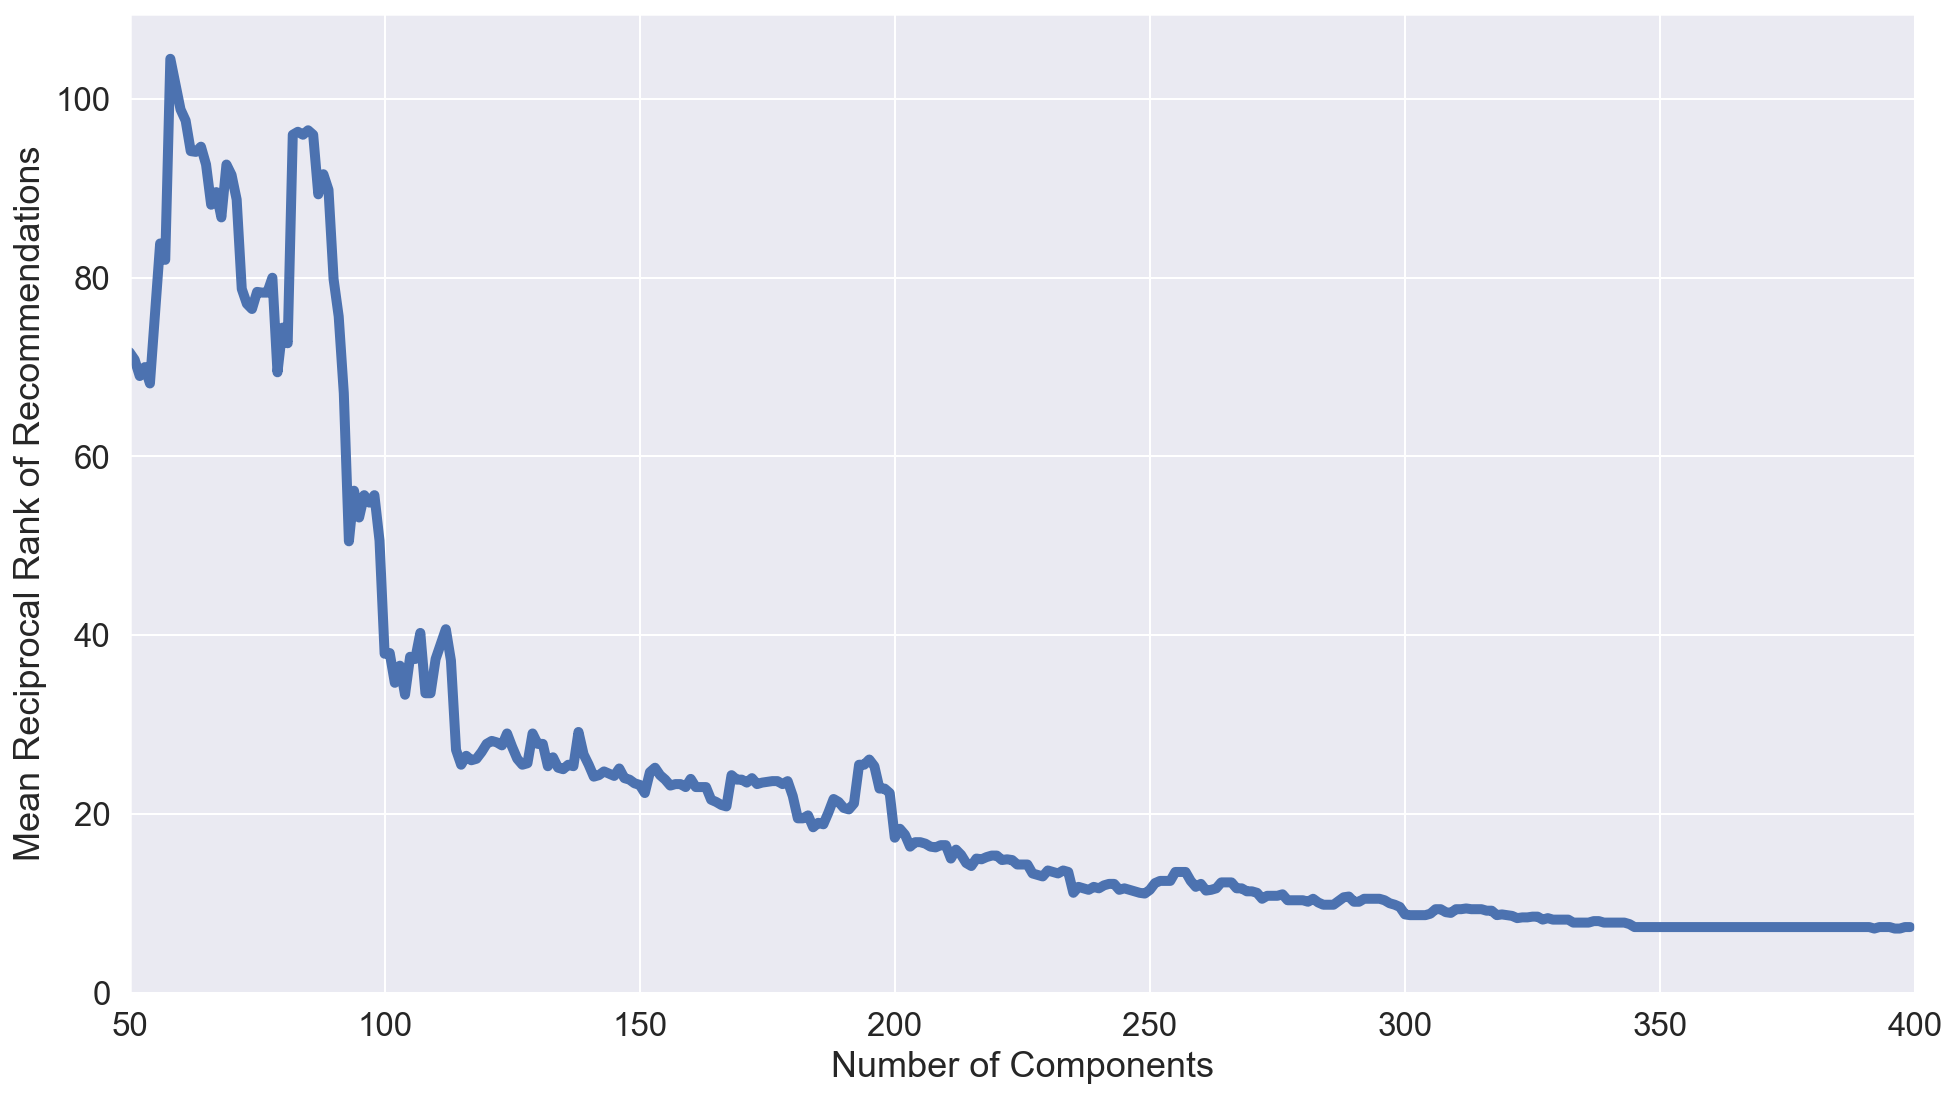

In [189]:
# Plot MRR vs. number of components

plt.plot(df_comp_res['n_components'], df_comp_res['MRR'],
        linewidth=5)
plt.xlim(50, 400)
plt.ylim(0, df_comp_res['MRR'].max()+5)
plt.xlabel("Number of Components")
plt.ylabel("Mean Reciprocal Rank of Recommendations")

- Increasing the number of components improves the performance of the recommender but no clear cut-off
- Maybe around 350, the results appear to stabilize close to the minimum

In [247]:
# Round MRR values to 4 decimals
df_comp_res['MRR_rd'] = df_comp_res['MRR'].round(4)

In [248]:
df_plot = df_comp_res.loc[(df_comp_res["n_components"] > 250) & (df_comp_res["n_components"] < 375)]

Text(0, 0.5, 'Mean Reciprocal Rank of Recommendations')

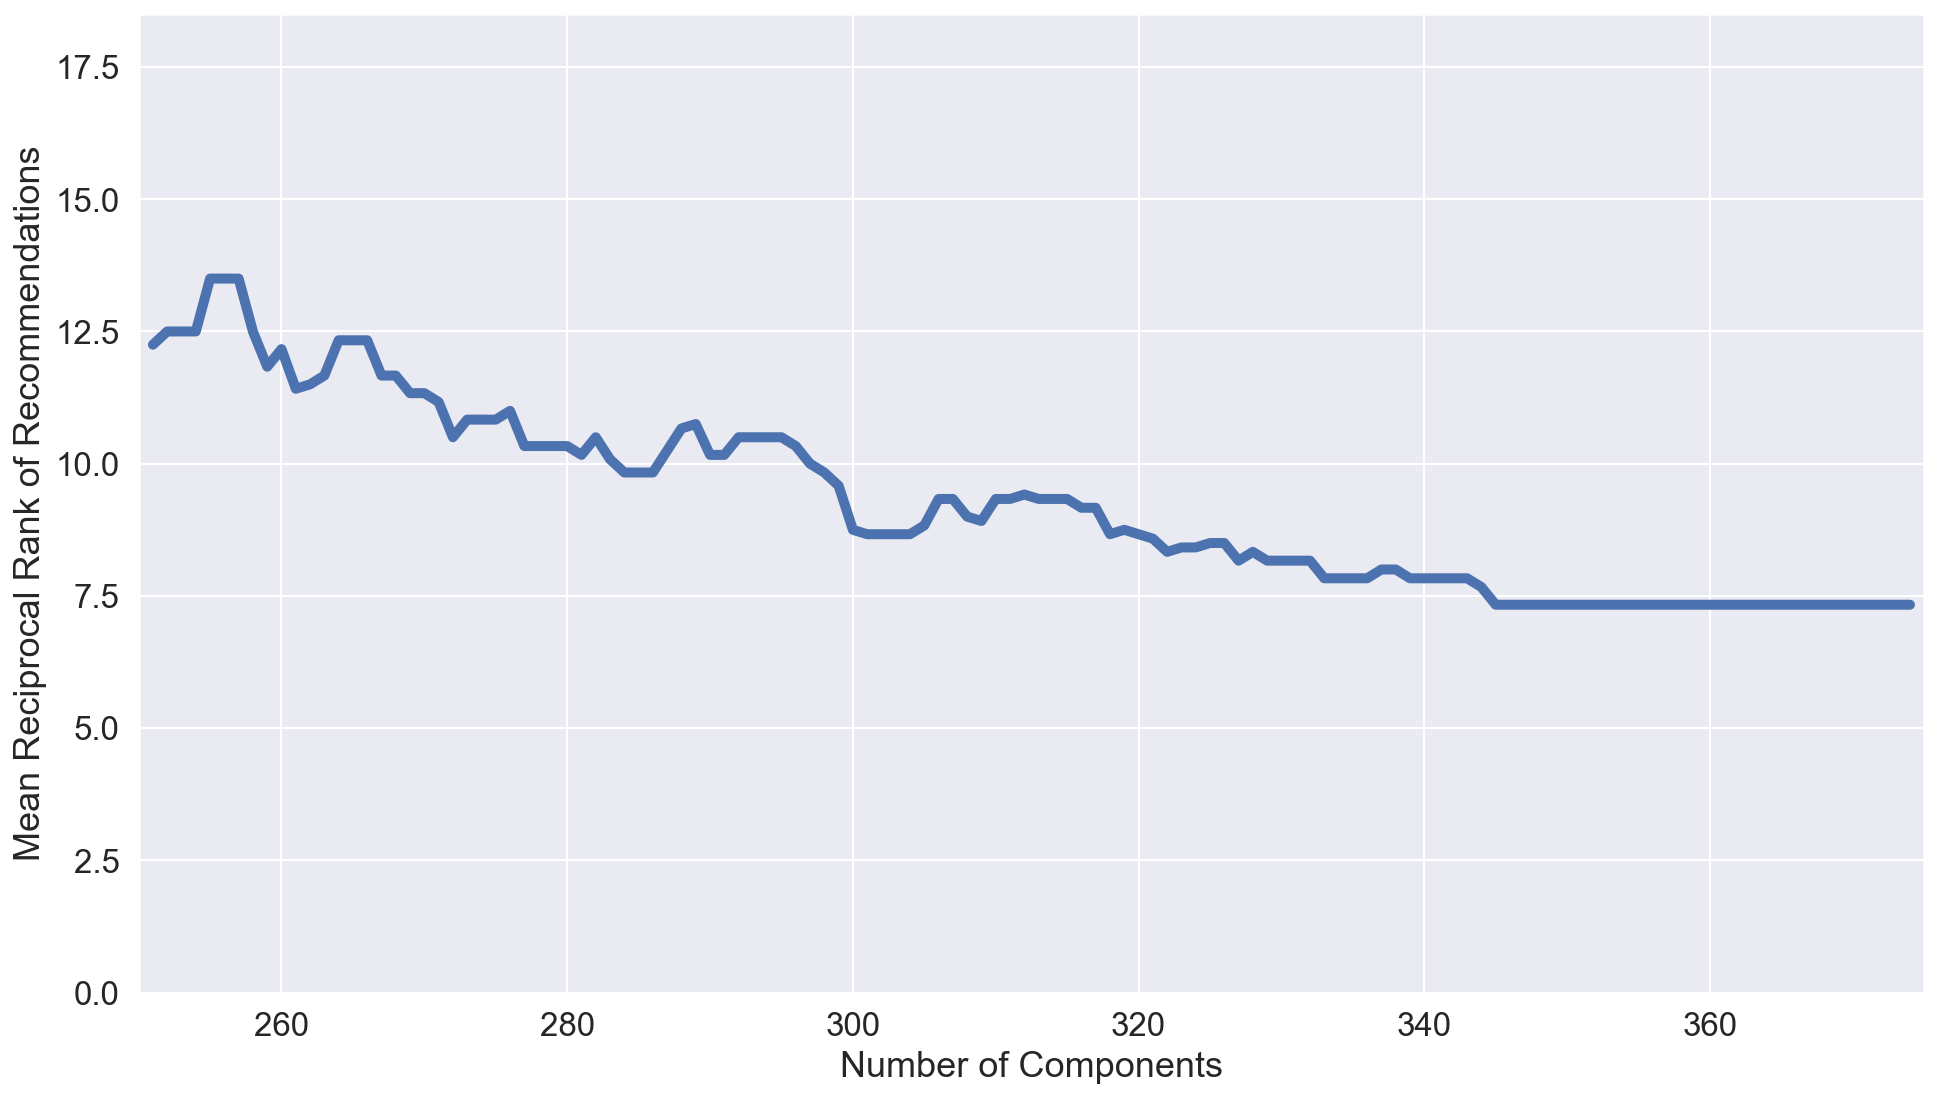

In [249]:
# Check relationship between MRR and # of components around 250-350

plt.plot(df_plot['n_components'], df_plot['MRR'],
        linewidth=5)
plt.xlim(250, 375)
plt.ylim(0, df_plot['MRR'].max()+5)
plt.xlabel("Number of Components")
plt.ylabel("Mean Reciprocal Rank of Recommendations")

In [250]:
df_plot['MRR_rd'].values

array([12.25  , 12.5   , 12.5   , 12.5   , 13.5   , 13.5   , 13.5   ,
       12.5   , 11.8333, 12.1667, 11.4167, 11.5   , 11.6667, 12.3333,
       12.3333, 12.3333, 11.6667, 11.6667, 11.3333, 11.3333, 11.1667,
       10.5   , 10.8333, 10.8333, 10.8333, 11.    , 10.3333, 10.3333,
       10.3333, 10.3333, 10.1667, 10.5   , 10.0833,  9.8333,  9.8333,
        9.8333, 10.25  , 10.6667, 10.75  , 10.1667, 10.1667, 10.5   ,
       10.5   , 10.5   , 10.5   , 10.3333, 10.    ,  9.8333,  9.5833,
        8.75  ,  8.6667,  8.6667,  8.6667,  8.6667,  8.8333,  9.3333,
        9.3333,  9.    ,  8.9167,  9.3333,  9.3333,  9.4167,  9.3333,
        9.3333,  9.3333,  9.1667,  9.1667,  8.6667,  8.75  ,  8.6667,
        8.5833,  8.3333,  8.4167,  8.4167,  8.5   ,  8.5   ,  8.1667,
        8.3333,  8.1667,  8.1667,  8.1667,  8.1667,  7.8333,  7.8333,
        7.8333,  7.8333,  8.    ,  8.    ,  7.8333,  7.8333,  7.8333,
        7.8333,  7.8333,  7.6667,  7.3333,  7.3333,  7.3333,  7.3333,
        7.3333,  7.3

In [255]:
def select_best_n_components(df, selection_criteria):
    """
    Purpose: Find the best number of components to use 
    Returns: Number of components to use and the corresponding accuracy
    df: Dataframe of components and percent accuracy results
    selection_criteria: value to use to select the minimum number of 
        components
    """
    # Find the smallest number of components that meet the selection criteria
    n_comp = df[df['MRR_rd']==selection_criteria] \
                    .nsmallest(1, 'n_components') \
                    ['n_components'].values
    # change to integer
    n_comp = int(n_comp)
    return n_comp    

In [256]:
# Find the best number of components to use

selection_criteria = 7.3333 #df_comp_res['MRR_rd'].min()
# Use custom selection criteria since min gains are too small

best_n_comp = select_best_n_components(df_comp_res,
                                    selection_criteria)

print(f"{best_n_comp} is the minimum number of components needed to reach the minimum Mean Reciprocal Rank of {selection_criteria}")

345 is the minimum number of components needed to reach the minimum Mean Reciprocal Rank of 7.3333


In [315]:
# Calculate the percent decrease in features from TSVD

original_n_comp = 400
new_n_comp = best_n_comp
comp_decrease = original_n_comp-new_n_comp

perc_decrease = round((comp_decrease/original_n_comp) * 100,2)

print(f"Feature component selection of {new_n_comp} resulted in a {perc_decrease}% decrease compared to the original {original_n_comp} components")

Feature component selection of 345 resulted in a 13.75% decrease compared to the original 400 components


## Validation
### Recommendations for brand vs. generic versions

In [258]:
# Update number of components to use

df_tsvd_full_features = get_components_df(df_tsvd_full, best_n_comp) 

In [259]:
# Update recommendation accuracy for list of brand name products

df_valid_ranks = get_ranks(brand_name_prod, prod_df=df_tsvd_full,
                                feat_df=df_tsvd_full_features)

In [262]:
# Calculate mean reciprocal rank

mean_rr = df_valid_ranks['cos_rank'].mean().round(2)
median_rr = df_valid_ranks['cos_rank'].median().round(2)

print(f"The Mean Reciprocal Rank (Mean RR) for the recommender is {mean_rr}")
print(f"The Median Reciprocal Rank (Median RR) for the recommender is {median_rr}")

print(f"A Mean RR of 1 indicates the recommender ranks the correct recommendation first on average. An MRR of 7.33 indicates the recommender ranks the correct recommendation in 7th place on average. However, the histogram indicates this is due to an outlier product, and the recommender otherwise ranks the correct product first (Median RR = {median_rr}).")

The Mean Reciprocal Rank (Mean RR) for the recommender is 7.33
The Median Reciprocal Rank (Median RR) for the recommender is 1.0
A Mean RR of 1 indicates the recommender ranks the correct recommendation first on average. An MRR of 7.33 indicates the recommender ranks the correct recommendation in 7th place on average. However, the histogram indicates this is due to an outlier product, and the recommender otherwise ranks the correct product first (Median RR = 1.0).


### Recommendations for brand vs. generic versions - randomization result

In [267]:
def get_ranks_rand(prod_list, df_tsvd, randiter):
    """
    Purpose: Gets recommendation accuracy results from randomization with 
        randiter reshuffling. Recommended minimum is 1000
    Returns: df of randomization results
    prod_list: list of product names for calculating cosine similarities
    df_tsvd: dataframe of tsvd results
    randiter: Number of randomization iterations to run
    """

    from numpy import random
    import sys, os
    
    # Initialize empty lists for storing results
    iteration = []
    mean_rr = []
    
    # create list of non-feature columns for the get_features function
    prod_info = ['use_category', 'brand', 'brand_generic',
                 'size', 'price', 'link']
    
    # Perform randomization and calculate correct recommendations each time
    for i in range(randiter-1):
        # Randomize the product names for tsvd results df 
        df_tsvd['product'] = random.permutation(df_tsvd['product'].values)
        # get df of randomized features (using reduced number of components)
        df_tsvd_feat = get_components_df(df_tsvd_full, best_n_comp) 
        # Get accuracy of recommendations
        df_valid_res = get_ranks(prod_list, 
                                 prod_df=df_tsvd,
                                 feat_df=df_tsvd_feat)
        # Calculate the Mean reciprocal rank for list of brand name products
        df_valid_ranks = df_valid_res['cos_rank'].mean()
        # Append results to lists
        iteration.append(i)
        mean_rr.append(df_valid_ranks)
    
    # Concatenate results into df
    df_overall_res = pd.DataFrame(list(zip(iteration, mean_rr)),
                                      columns=['iteration','MRR'])
    
    return df_overall_res

In [286]:
# Get results from randomization

df_rand_res = get_ranks_rand(prod_list=brand_name_prod,
                            df_tsvd=df_tsvd_full,
                            randiter=1000)

Text(0, 0.5, 'Counts')

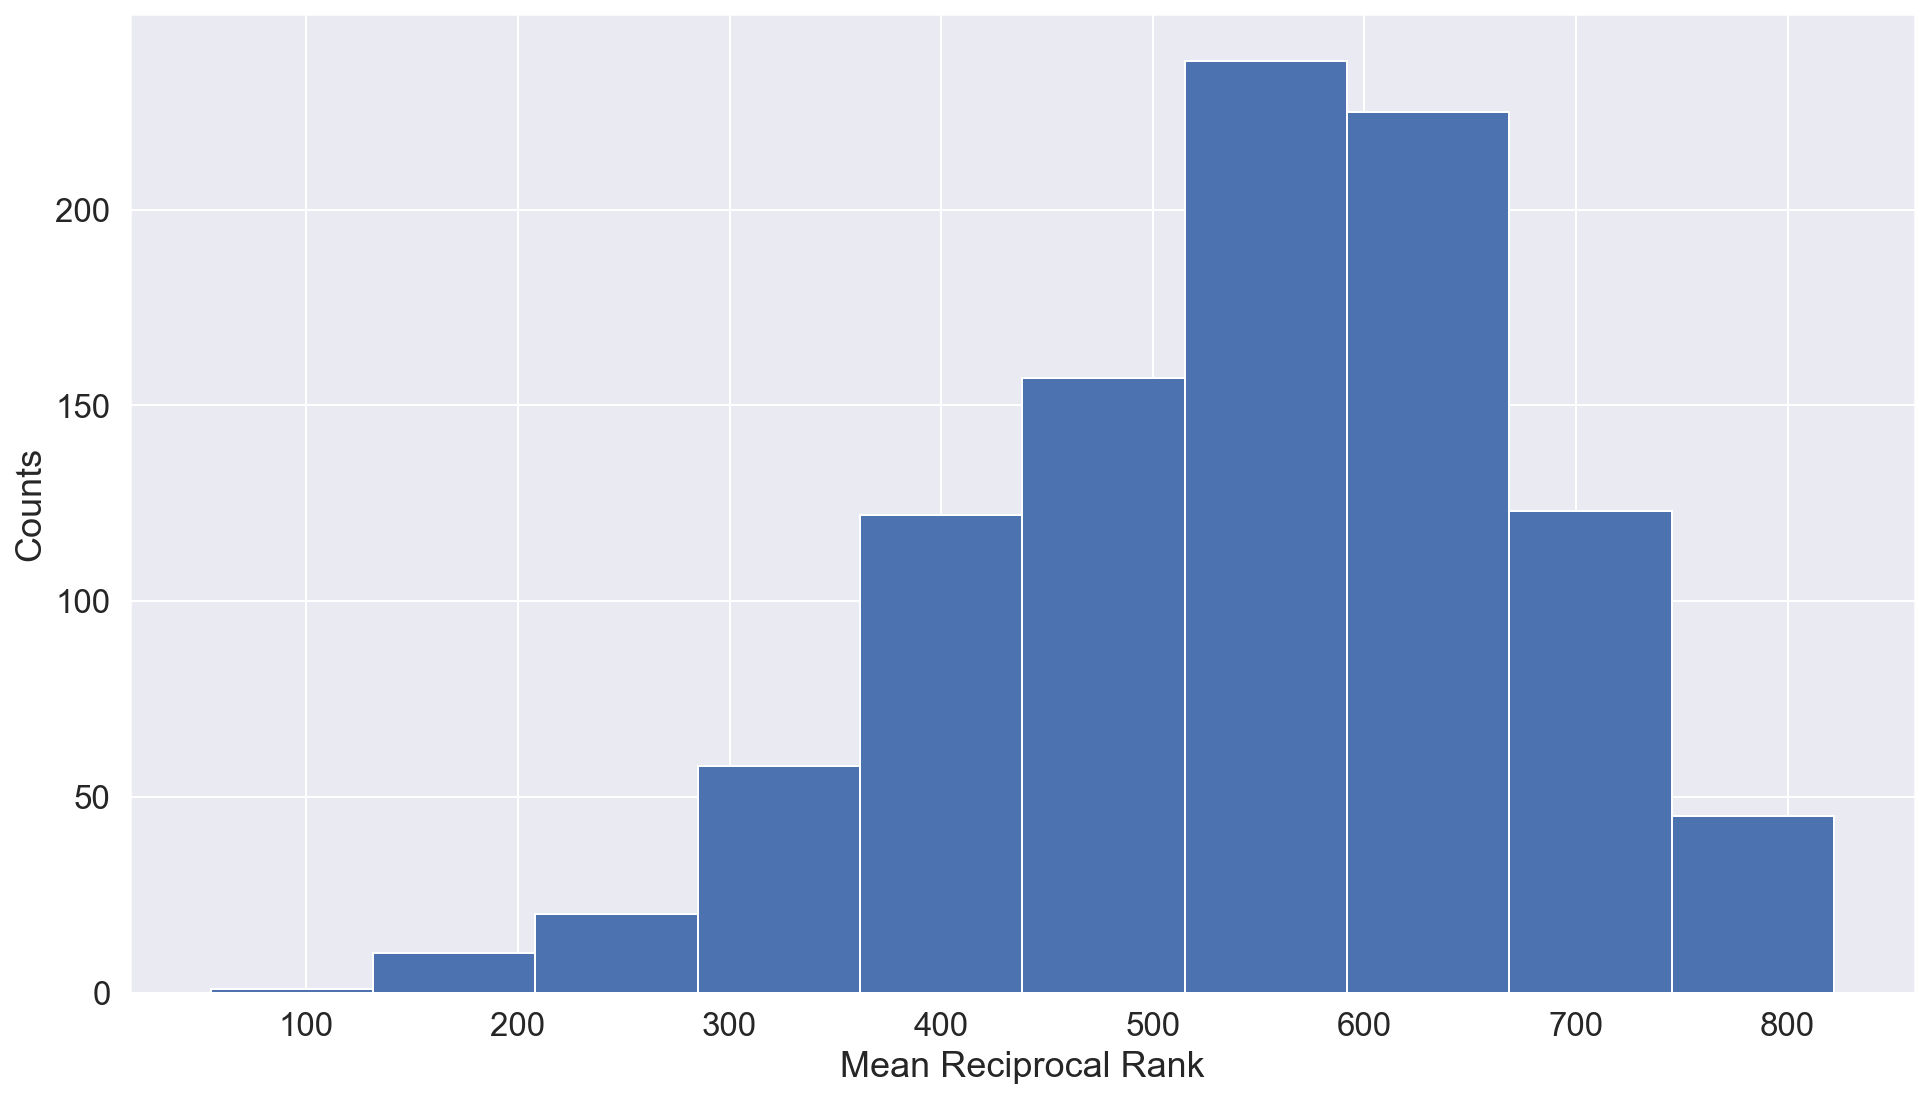

In [313]:
# Plot distribution of randomization results

df_rand_res['MRR'].hist()
plt.title('')
plt.xlabel('Mean Reciprocal Rank')
plt.ylabel('Counts')

In [288]:
# Save randomization output

filename = 'data_brand_gen_rand.csv'
df_rand_res.to_csv(rpath+directory_name+filename)

In [309]:
def get_mrr_p_val(original_df, rand_df):
    """
    Purpose: Print the p-value for the results observed compared to random 
        chance expectation
    Returns:
    original_df: df of results from original 
        accuracy assessment of recs
    rand_df: df of results from randomization
    """
    # Get original MRR 
    mrr_original = original_df['cos_rank'].mean()

    # Get the proportion of randomization results that were equal to 
    #   or less than the original MRR
    rand_p_val = (
        (rand_df.MRR[rand_df['MRR'] <= \
                             mrr_original].sum()/1000) * 100
    )
    
    text = f"The probability of observing the original recommendation " \
           f"MRR of {mrr_original.round(0)} if the results were due " \
           f"to random chance is <= {rand_p_val.round(3)}%"

    print(text)
    
    return rand_p_val

In [310]:
rand_p_val = get_mrr_p_val(df_valid_ranks, df_rand_res)

The probability of observing the original recommendation MRR of 7.0 if the results were due to random chance is <= 0.0%


In [311]:
# calculate the average accuracy from the randomization results

rand_mean_mrr = round(df_rand_res['MRR'].mean(),2)
rand_med_mrr = round(df_rand_res['MRR'].median(),2)
rand_min_mrr = round(df_rand_res['MRR'].min(),2)
rand_max_mrr = round(df_rand_res['MRR'].max(),2)

print(f"The average recommendation MRR for the 1000 randomizations " \
      f"is: {rand_mean_mrr}%")
print(f"The median recommendation MRR for the 1000 randomizations " \
      f"is: {rand_med_mrr}%")
print(f"Recommendation MRR for the 1000 randomizations " \
      f"ranges from {rand_min_mrr}% to {rand_max_mrr}%")

The average recommendation MRR for the 1000 randomizations is: 545.75%
The median recommendation MRR for the 1000 randomizations is: 559.33%
Recommendation MRR for the 1000 randomizations ranges from 54.83% to 821.92%


In [312]:
# Calculate the percentage improvement of the recommender over the randomization results

mrr_improve = df_valid_ranks['cos_rank'].mean()

decrease_from_baseline = (
    float(rand_mean_mrr-df_valid_ranks['cos_rank'].mean())
)
rand_baseline = rand_mean_mrr

perc_decrease = (decrease_from_baseline/rand_baseline) * 100

print(f"The recommender improved the MRR of the recommendations (MRR = {mrr_improve.round(0)}) by {perc_increase.round(2)}% compared to the performance of random chance recommendations (MRR = {rand_baseline.round(0)})")

The recommender improved the MRR of the recommendations (MRR = 7.0) by 98.66% compared to the performance of random chance recommendations (MRR = 546.0)
